In [3]:
import numpy as np
import networkx as nx
import torch
import time
from sklearn.preprocessing import OneHotEncoder
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt

In this part, we focus on a simple road map (rep as a graph below), and generate random path on it.
<img src="img/naive_road.png" alt="Drawing" style="width: 400px;"/>

In [20]:
def one_hot(x, N = 24):
    l = np.zeros(24)
    l[x] = 1
    return l
def inv_one_hot(l, N = 24):
    return np.argmax(l)

In [21]:
def build_graph():
    G=nx.Graph()
    G.add_nodes_from(range(24))
    G.add_edges_from([(i, i+1) for i in range(5)] 
                     + [(i+6, i+7) for i in range(5)] 
                     +[(i+12, i+13) for i in range(5)]
                     + [(i+18, i+19) for i in range(5)]
                     + [(0,6),(6,12), (12,18)]
                     + [(pair[0]+1, pair[1]+1) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+2, pair[1]+2) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+3, pair[1]+3) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+4, pair[1]+4) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+5, pair[1]+5) for pair in [(0,6),(6,12), (12,18)]]
                     )
    return G

In [22]:
# gloable env
G = build_graph() 
N = len(G.node)

In [23]:
def random_path(start = None, stop_prob = 0.1):
    """
    Generate (hist dependent) random path on graph G with lenght at least 2, encode each road in one-hot fashion
    """
    if not start:
        start = np.random.choice(24)
    path = [start]
    prev = None
    while True:
        neighbors = list(G.neighbors(start))
        if prev:
            neighbors.remove(prev)
        nxt = np.random.choice(neighbors)
        path.append(nxt)
        prev = start
        start = nxt
        if np.random.rand() < stop_prob:
            break
    return np.array(path)

In [2]:
p = random_path()
type(p)

NameError: name 'random_path' is not defined

In [25]:
def random_training_set():
    def f(x):
        if x == -1:
            return 0
        if x == -6:
            return 1
        if x == 1:
            return 2
        if x == 6:
            return 3
    path = random_path()
    inp = torch.from_numpy(np.float32(np.array([one_hot(p) for p in path[:-1]])))
    #import pdb; pdb.set_trace()
    tar = [f(x) for x in path[1:] - path[:-1]]
    tar = torch.from_numpy(np.array(tar))
    return Variable(inp).contiguous(), Variable(tar).contiguous()

In [26]:
x,y = random_training_set()
print('x: {} is the sequence of road'.format([inv_one_hot(r) for r in x.data.numpy()]))
print('y: {} denotes the turning decistion at each road'.format(y.data.numpy()))

x: [17, 11, 5, 4, 3, 9, 10, 16] is the sequence of road
y: [1 1 0 0 3 2 3 0] denotes the turning decistion at each road


In [27]:
x.size()

torch.Size([8, 24])

Since we know the road transition are markov (turing decision only depends on current road), let start with *none-recurrent nn* to fit our transition

In [28]:
N_batch, D_in, D_hidden, D_out = 50, 24, 100, 4
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(D_hidden, D_out),
    torch.nn.Softmax(dim = 1),
)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L = 0
n = 0
pts = {'x':[], 'y':[]}
for t in range(40000):
    x,y = random_training_set()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    L += sum(loss.data.numpy())
    n += len(loss.data.numpy())
    if t%1000 == 0:
        pts['x'].append(t)
        pts['y'].append(L/n)
        print(t, L/n)
        L = 0
        n = 0
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 1.37819850445
1000 1.34877903509
2000 1.33120799512
3000 1.32862410265
4000 1.32943869406
5000 1.32465750802
6000 1.32555015749
7000 1.32954445332
8000 1.32621114218
9000 1.32568065423
10000 1.32548093247
11000 1.32437729979
12000 1.32074341965
13000 1.32128197074
14000 1.32473915815
15000 1.32424815494
16000 1.3237808935
17000 1.32439106894
18000 1.32236599803
19000 1.3225575881
20000 1.32397578615
21000 1.31950148171
22000 1.32488259333
23000 1.32150407481
24000 1.32304141831
25000 1.32087023312
26000 1.32444464266
27000 1.3235664289
28000 1.32241386473
29000 1.32391683674
30000 1.32232768738
31000 1.32359079611
32000 1.32143762124
33000 1.31737536812
34000 1.32246897364
35000 1.32358184755
36000 1.32395185101
37000 1.32329974055
38000 1.31970926344
39000 1.32391404307


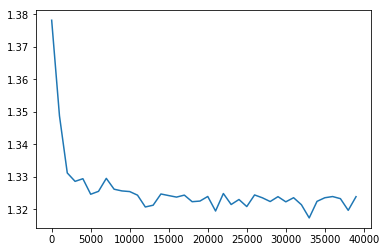

In [29]:
plt.plot(pts['x'],pts['y'])

In [30]:
x,y = random_training_set()
print([inv_one_hot(r) for r in x.data.numpy()])
model(x)

[5, 11, 10]


Variable containing:
 0.4820  0.0001  0.0000  0.5179
 0.3676  0.3142  0.0000  0.3182
 0.3077  0.2789  0.1808  0.2327
[torch.FloatTensor of size 3x4]

Clearly, the naive nn is not enough.
# RNN for Tracking the History

In [39]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.lin = nn.Linear(hidden_size, output_size)
        self.sm = nn.Softmax(dim = 2)
        
        hidden0 = torch.zeros(n_layers, 1, hidden_size)
        self.hidden0 = nn.Parameter(hidden0, requires_grad=True)
    
    def forward(self, inp, hidden):
        output, hidden = self.gru(inp.view(1, 1, self.input_size), hidden)
        output = self.lin(output) 
        output = self.sm(output)
        return output, hidden
    
    def init_hidden(self):
        return self.hidden0
    #def init_hidden(self):
    #    return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [32]:
def train(inp, target):
    hidden = rnn.init_hidden() 
    rnn.zero_grad()
    hat = []
    for i in range(len(inp)):
        output, hidden = rnn(inp[i,:], hidden)
        hat.append(output.view(-1,4))
    pred = torch.cat(hat)
    loss = loss_fn(pred, target)
    rnn_optimizer.zero_grad()
    loss.backward()
    rnn_optimizer.step()
    return pred, loss.data[0]

In [33]:
N_batch, D_in, D_hidden, D_out = 50, 24, 200, 4
rnn = RNN(D_in, D_hidden, D_out, n_layers = 1)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.0002
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
L = 0
pts = {'x':[], 'y':[]}
for t in range(1,400001):
    x,y = random_training_set()
    _, loss = train(x,y)
    
    L += loss
    if t%10000 == 0:
        pts['x'].append(t)
        pts['y'].append(L/10000)
        print(t, L/10000)
        L = 0

10000 1.286091720533371
20000 1.2516227767646313
30000 1.2476900822401047
40000 1.2422941454291343
50000 1.2401497869372369
60000 1.2390156372785568
70000 1.2365963279604912
80000 1.2335477594792843
90000 1.2303391821324825
100000 1.230012923693657
110000 1.2306775426208973
120000 1.2277813690721988
130000 1.2270576486170293
140000 1.2276011325895786
150000 1.2275342661499977
160000 1.228600606149435
170000 1.2282477041065694
180000 1.228779377555847
190000 1.2264574523568152
200000 1.226555451208353
210000 1.2266811502873898
220000 1.2266467179477214
230000 1.2258391895890235
240000 1.227276900303364
250000 1.2261577071368694
260000 1.226163866341114
270000 1.2274386729240419
280000 1.2247353821992875
290000 1.2273381299853325
300000 1.225574891871214
310000 1.2249735207259655


KeyboardInterrupt: 

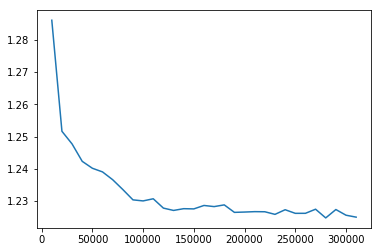

In [34]:
plt.plot(pts['x'],pts['y'])

In [35]:
x,y = random_training_set()
pred,_ = train(x,y)
print([inv_one_hot(r) for r in x.data.numpy()])
print(pred)

[13, 7, 8, 2, 3, 4]
Variable containing:
 3.3245e-01  1.9453e-01  2.1593e-01  2.5709e-01
 2.6542e-01  4.3333e-01  2.8481e-01  1.6435e-02
 9.0449e-03  5.1083e-01  3.2381e-01  1.5632e-01
 3.9767e-01  1.9064e-05  5.9889e-01  3.4207e-03
 4.9464e-03  8.7184e-06  6.1532e-01  3.7973e-01
 5.5006e-03  4.6562e-06  6.3331e-01  3.6119e-01
[torch.FloatTensor of size 6x4]



In [ ]:
def generate(start):
    hidden = rnn.init_hidden()
    inp = start
    predicted = inp.data.view(1,2)
    
    for i in range(1, 1000):
        output, hidden = rnn(inp, hidden)
        predicted = torch.cat([predicted, output.data.view(1,2)])
        inp = output
    return predicted